#Entrega 2. Generación de un clasificador multiclase de objetos basado en radar 2D

##Apartado 1

Cargar los datos “Entregable2.RData”

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%matplotlib inline
%config IPCompleter.greedy=True #comando para que las graficas nos queden al lado de la celda

Mounted at /content/drive


In [2]:
pip install pyreadr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 418.3/418.3 kB 4.7 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
import pyreadr #este es especifico para poder leer el archivo .RData proporcionado, necesario instalarlo
from scipy.stats import median_abs_deviation

El archivo de R, tiene 2 archivos. Por lo tanto tenemos que unir estos archivos en uno solo para poder tener la tabla toda junta

In [4]:
result = pyreadr.read_r("/content/drive/MyDrive/ML/Entrega_2_Ander/Entregable2.RData")

# Ver qué contiene
X = result['X']  # DataFrame con variables explicativas
y = result['y']  # Vector o serie con la variable respuesta

print(X.shape)
print(y.shape)

y = y.squeeze()

df = X.copy()
df['y'] = y.values

(400000, 9)
(400000, 1)


In [5]:
df.head()

,range_sc,azimuth_sc,radar_cross_section,radial_velocity,vr_compensated,x_cc,y_cc,x_seq,y_seq,y
1,43.622902,0.219503,-4.362511,-1.106540,1.432126,46.462830,-10.078518,-219.668960,-74.771560,8
2,43.986267,0.182418,-4.963240,-0.387444,-0.387444,46.437542,-11.742858,-223.496780,-72.787030,8
3,37.649033,0.612367,-7.751697,-5.522038,-0.985286,40.926235,5.898777,25.178608,17.521221,8
4,56.625446,-0.349071,-0.764038,-2.996644,-1.190873,43.905914,-40.734560,-177.300050,-57.968410,7
5,28.673414,0.623958,3.215949,0.667195,0.667195,32.029408,4.652500,-213.484910,-68.389175,8


##Apartado 2

Reasignar las etiquetas de autobús (3) y camión (2) a vehículo grande
(1) y la etiqueta grupo de personas (8) a persona (7) en la variable
respuesta y.

In [6]:
df['y']=df['y'].replace({3:1,2:1,8:7})
#valores unicos
(df['y']).unique()
#vemos que ya no tenemos los valores 3,2 y 8

array([ 7,  0, 11, 10,  5,  1], dtype=int32)

In [7]:
df.sort_values(by='y')
print(len(df))
print(len(df.iloc[200000:400000]))
print(len(df.iloc[200000:]))

400000
200000
200000


##Apartado 3

Separar los datos iniciales (X e y) en “train” y “validation”

In [8]:
#primeros 200000 registros para train
train = df.iloc[0:200000]
#los siguientes 20000 para test
test = df.iloc[200000:]


##Apartado 4

Graficar el valor de Radar Cross Section (RCS) mediana ± mad para las
clases Persona (7) y Vehículo grande (1) en función de la distancia (range)
en el set de “Train”. ¿Existe diferencia significativa en términos de RCS
entre la clase Persona (7) y Vehículo grande (1)? Justifica tu respuesta.

/tmp/ipython-input-4237271531.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = subset.groupby(pd.cut(subset['range_sc'], bins))
/tmp/ipython-input-4237271531.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = subset.groupby(pd.cut(subset['range_sc'], bins))


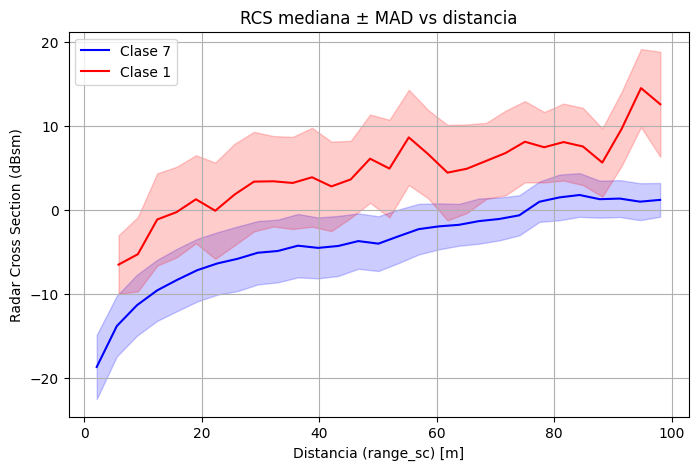

In [9]:
def plot_rcs_vs_range(df, clase, color):
    subset = df[df['y'] == clase]
    bins = np.linspace(subset['range_sc'].min(), subset['range_sc'].max(), 30)
    groups = subset.groupby(pd.cut(subset['range_sc'], bins))
    rcs_median = groups['radar_cross_section'].median()
    rcs_mad = groups['radar_cross_section'].apply(median_abs_deviation)
    centers = [interval.mid for interval in rcs_median.index]

    plt.plot(centers, rcs_median, color=color, label=f'Clase {clase}')
    plt.fill_between(centers, rcs_median - rcs_mad, rcs_median + rcs_mad,
                     color=color, alpha=0.2)

plt.figure(figsize=(8,5))
plot_rcs_vs_range(train, 7, 'blue')  # persona
plot_rcs_vs_range(train, 1, 'red')   # vehículo grande
plt.xlabel("Distancia (range_sc) [m]")
plt.ylabel("Radar Cross Section (dBsm)")
plt.title("RCS mediana ± MAD vs distancia")
plt.legend()
plt.grid(True)
plt.show()

A primera vista, se aprecia como hay diferencia entre la detección en personas (azules) y vehiculos grandes (rojo). Se puede observar como ante una misma distancia de deteccion los vehiculos grandes son mas visibles ante el radar que las personas. Tiene, desde luego, lógica física.
Por otro lado, los dBsm representan cuan visible es el objeto para el radar. En ambos casos vemos como a medida que el objeto esta más alejado los dBsm son mayores, lo cual, a bote pronto, puede parecer contraproducente. No obstante, muchas veces los radares tienen incorporados ya un calculo para compensar la potencia del radar en funcion del decaimiento de la distancia y por ello nos aparecen las graficas crecientes en vez decrecientes como, en teoría, deberían de estar (a menor distancia, mejor se distingue el objeto).

In [10]:
# Crear una versión "no compensada" (potencia recibida aproximada)
df["rcs_raw_db"] = df["radar_cross_section"] - 40 * np.log10(df["range_sc"] + 1e-3)

/tmp/ipython-input-2247328667.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = subset.groupby([cats, "y"])["rcs_raw_db"]


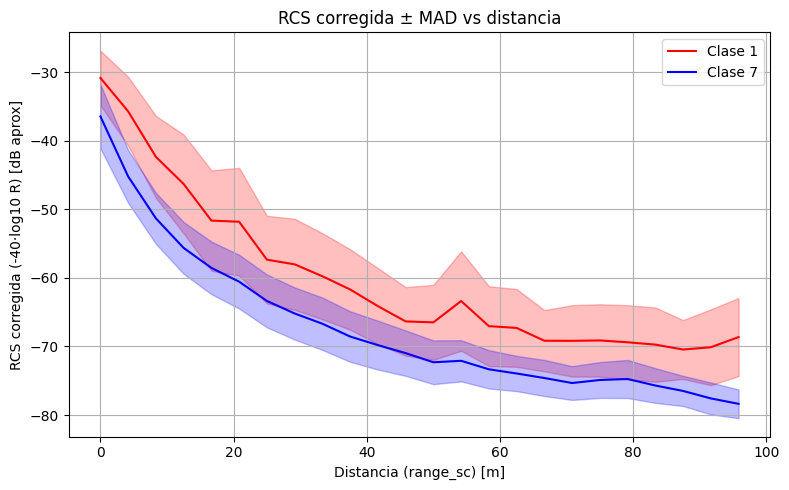

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#creamos la RCS "no compensada" (quitando el término ~R^4)
df["rcs_raw_db"] = df["radar_cross_section"] - 40*np.log10(df["range_sc"] + 1e-3)

#función MAD por grupo (median absolute deviation)
def mad_series(s):
    m = np.median(s)
    return np.median(np.abs(s - m))

#agrupamos por bins de distancia y calculamos mediana y MAD
subset = df[df["y"].isin([1, 7])]  #clases 1 y 7
bins = np.linspace(0, 100, 25)
cats = pd.cut(subset["range_sc"], bins)

grp = subset.groupby([cats, "y"])["rcs_raw_db"]
med = grp.median().unstack("y")
mad = grp.apply(mad_series).unstack("y")

#pasamos a representar
plt.figure(figsize=(8,5))
for cls, color in zip([1,7], ["red","blue"]):
    x = bins[:-1]
    y_med = med[cls].values
    y_mad = mad[cls].values
    plt.plot(x, y_med, color=color, label=f"Clase {cls}")
    plt.fill_between(x, y_med - y_mad, y_med + y_mad, color=color, alpha=0.25)

plt.xlabel("Distancia (range_sc) [m]")
plt.ylabel("RCS corregida (-40·log10 R) [dB aprox]")
plt.title("RCS corregida ± MAD vs distancia")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


En esta nueva grafica se ve como las diferencias entre clases se sigue apreciando y, además, vemos como la potencia para distancias menores es mayor.

##Apartado 5

Generar un modelo multiclase de objetos y obtener el AP (Average Precision) por cada clase vs resto y el mAP (mean Average Precision) en entrenamiento y en validación

In [12]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split

In [13]:
#dividimos entre x e y en el train y test
x_train = train.drop(columns=['y'])
y_train = train['y']

x_test = test.drop(columns=['y'])
y_test = test['y']

#cogemos una muestra del test para que computacionalmente no tengamos problemas
train_sample = x_train.sample(n=50000, random_state=42)
y_sample = y_train.loc[train_sample.index]

print("Train reducido:", train_sample.shape) #de 200000 muestras pasamos a 50000

Train reducido: (50000, 9)


In [14]:
#para añadir interacciones entre variables tal y como indica el enunciado
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
x_train_poly = poly.fit_transform(train_sample)
x_test_poly = poly.transform(x_test)

Este tipo de interacciones cruzadas permiten modelar efectos combinados sin necesidad de modelos más complejos.

In [15]:
#pasamos a escalar los valores ya que las unidades son diferentes y por lo tanto, las escalas tambien
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_poly)
x_test_scaled = scaler.transform(x_test_poly)

En este caso necesitamos escalar puesto que las unidades entre las variables son diferentes.

In [ ]:
#Entrenamos el modelo (RandomForest)
modelo_class = RandomForestClassifier( #creamos el modelo
    n_estimators=200, #200 estimadores o arboles
    max_depth=12, #profundidad maxima de 12 por arbol
    n_jobs=-1, #utiliza todos los cores disponibles
    random_state=42 #para futura reproducibilidad
)
modelo_class.fit(x_train_scaled, y_sample) #entrenamiento del modelo

RandomForestClassifier(max_depth=12, n_estimators=200, n_jobs=-1,
                       random_state=42)

In [ ]:
#pasamos a obtener las predicciones del modelo tanto con los datos de train como con los de test
classes = modelo_class.classes_ #sacamos las calses del modelo
y_train_proba = modelo_class.predict_proba(x_train_scaled) #hacemos la prediccion con los datos de entrenamiento
y_test_proba = modelo_class.predict_proba(x_test_scaled) #hacemos la prediccion con los datos de test

Tanto en "y_train_proba" como en "y_test_proba", lo que obtenemos es por cada fila (cada muestra) un vector con las probabilidades de dicha muestra de pertenecer a cada una de las clases. Luego, con estas probabilidades, se decide que clase acaba siendo la predicción.

In [ ]:
#pasamos a calcular el AP de cada clase vs el resto y el mAP
from sklearn.metrics import average_precision_score

ap_train = {}
ap_test = {}

for i, c in enumerate(classes):
    y_true_train = (y_sample == c).astype(int)
    y_true_test = (y_test == c).astype(int)

    ap_train[c] = average_precision_score(y_true_train, y_train_proba[:, i])
    ap_test[c] = average_precision_score(y_true_test, y_test_proba[:, i])

mAP_train = np.mean(list(ap_train.values()))
mAP_test = np.mean(list(ap_test.values()))

Pasamos ahora a ver los resultados

In [ ]:
print("AP (train) de cada clase vs el resto")
print("\n")
for c, ap in sorted(ap_train.items(), key=lambda x: x[1]):
    print(c, ap)
print("\n")

print("AP (test) de cada clase vs el resto")
print("\n")
for c, ap in sorted(ap_test.items(), key=lambda x: x[1]):
    print(c, ap)
print("\n")

print("mAP train:",mAP_train)

print("\n")

print("mAP test:",mAP_test)


AP (train) de cada clase vs el resto


10 0.7938330393317858
11 0.8865535715229284
1 0.9590251118216006
0 0.9923473069308959
7 0.9929939729048586
5 0.9933322595177274


AP (test) de cada clase vs el resto


10 0.05097034057501293
5 0.1930001587547781
1 0.30505976262325807
0 0.4921329126432654
11 0.6791727862773189
7 0.874350801490299


mAP train: 0.9363475436716328


mAP test: 0.43244779372732206


Vemos como claramente hay un exceso de overfitting. Los resultados con los datos de entrenamiento son mucho mejores que con los datos de test. Además, también se puede observar como en ambos casos, el peor objeto que se detecta son el número 10 (otros objetos dinámicos).

##Apartado 6

¿Los valores de AP por clase vs resto mejoran en distancias más cercanas y ángulos de azimuth más próximos a 0? Justifica la respuesta.

Para realizar este apartado, necesitamos dividir los datos en funcion del "range_sc" y "azimuth_sc"

In [ ]:
#comprobamos valores minimos y maximos de cada una de las variables
print(df['range_sc'].min()) #0.43
print(df['range_sc'].max()) #99.7
print(df['azimuth_sc'].min()) #-1.2
print(df['azimuth_sc'].max()) #1.2

0.43025738
99.74932
-1.2216734
1.2212608


In [ ]:
#preparamos un df con todo junto
test_df = x_test.copy()
test_df['y_true'] = y_test.values

In [ ]:
#añadimos las probabilidades de todas las clases al df
for i, c in enumerate(classes):
    test_df[f'prob_{c}'] = y_test_proba[:, i]

In [ ]:
print(test_df.head())

    range_sc  azimuth_sc  radar_cross_section  radial_velocity  \
1  18.086618    0.585346            -6.227641       -20.672161   
2  31.720541   -0.325702            -8.158033        -0.001792   
3   8.963459   -0.185645           -16.800316         0.767346   
4  24.477306    0.169587            -6.680907        -0.895679   
5  22.335802    0.255039            -7.612679        -0.527860   

   vr_compensated       x_cc       y_cc       x_seq       y_seq  y_true  \
1       -9.941480  21.745789   1.987815 -185.411710 -282.884280       1   
2       -0.001416  26.810892 -22.596330 -221.876480  -41.929012      11   
3        0.767346  11.145622  -5.921428 -200.160540  -49.131165       7   
4        1.352425  27.472590  -7.148579  -62.744534 -171.078280       7   
5       -0.518025  25.830341  -4.723953  -50.206013 -195.966140       7   

     prob_0    prob_1    prob_5    prob_7   prob_10   prob_11  
1  0.832271  0.078681  0.000162  0.088641  0.000000  0.000245  
2  0.008529  0.002056  0

Vemos como tenemos la tabla con todos los datos juntos de inicio juntos con las probabilidades en cada de las muestras de ser cada uno de los objetos

Para definir que objetos son cercanos o lejanos y los que tienen un angulo pequeño o lejano, creamos un hitograma para ver la concentracion de cada una de las variables, ya que con los valores mínimos o máximos no basta (podría haber valores atípicos). Además dividimos de cada una de las variables en funcion de las clases para ver como cada una de ellas está distribuida

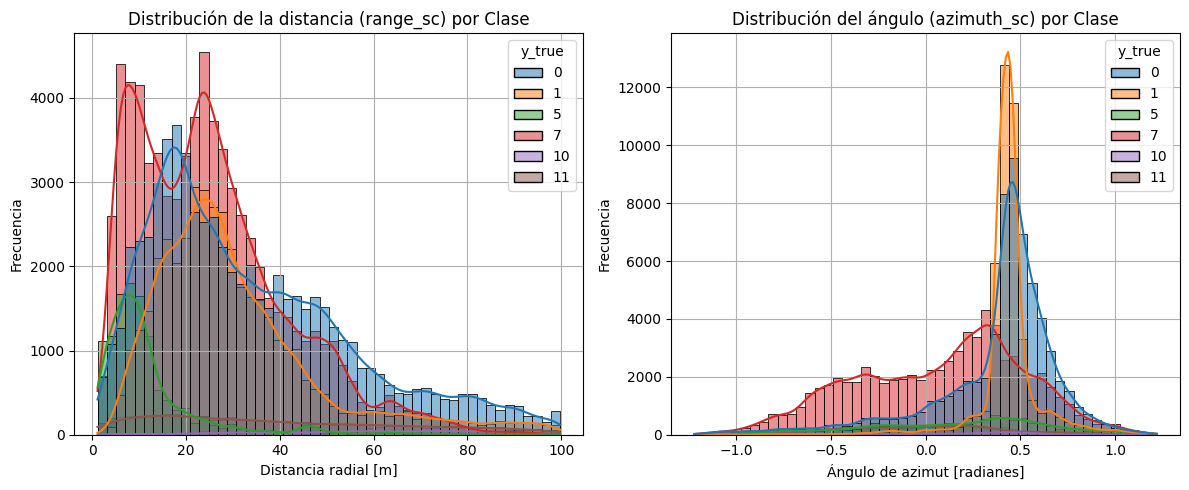

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#copiamos todos los valores de test_df en una nueva variable
grafico = test_df.copy()

#creamos ahora una variable para poder dividir el grafico en clases
grafico_melted = grafico.melt(id_vars=['y_true'], value_vars=['range_sc', 'azimuth_sc'],
                              var_name='Variable', value_name='Value')

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
sns.histplot(data=grafico_melted[grafico_melted['Variable'] == 'range_sc'], x='Value', hue='y_true', bins=50, kde=True, palette='tab10')
plt.title('Distribución de la distancia (range_sc) por Clase')
plt.xlabel('Distancia radial [m]')
plt.ylabel('Frecuencia')
plt.grid(True)

plt.subplot(1, 2, 2)
sns.histplot(data=grafico_melted[grafico_melted['Variable'] == 'azimuth_sc'], x='Value', hue='y_true', bins=50, kde=True, palette='tab10')
plt.title('Distribución del ángulo (azimuth_sc) por Clase')
plt.xlabel('Ángulo de azimut [radianes]')
plt.ylabel('Frecuencia')
plt.grid(True)

plt.tight_layout()
plt.show()

Vamos a comenzar comparando una clase para cada una de las divisiones (distancia y angulo) en el que su distribucion sea uniforme. En en el caso de la distancia, la clase 0, mientras que en el caso del angulo la clase 7 son son distribuciones uniformes

In [ ]:
#funcion para calcular el AP de una clase
def ap_clase(df, clase):

    y_true = (df['y_true'] == clase).astype(int)
    y_score = df[f'prob_{clase}']

    # Evita errores cuando hay todas o ninguna positiva
    if y_true.sum() > 0 and y_true.sum() < len(y_true):
        ap = average_precision_score(y_true, y_score)
    else:
        ap = np.nan

    return ap

In [ ]:
#definimos ahora los objetos que son cercanos o lejanos(range_sc) y los que tienen un angulo pequeño o grande (azimuth_sc)
rango_cercano = test_df[test_df['range_sc'] < 25]
rango_lejano  = test_df[test_df['range_sc'] >= 25]

azimut_centro = test_df[np.abs(test_df['azimuth_sc']) < 0.4]
azimut_lateral= test_df[np.abs(test_df['azimuth_sc']) >= 0.4]


Comprobamos el numero de muestras en cada uno de los grupos

In [ ]:
print("Muestras rango cercano:", len(rango_cercano))
print("Muestras rango lejano:", len(rango_lejano))

Muestras rango cercano: 101234
Muestras rango lejano: 98766


In [ ]:
print("Muestras rango cercano:", len(azimut_centro))
print("Muestras rango lejano:", len(azimut_lateral))

Muestras rango cercano: 83903
Muestras rango lejano: 116097


In [ ]:
ap_range_close_0_7 = ap_clase(rango_cercano, 0)
ap_range_far_0_7   = ap_clase(rango_lejano, 0)
ap_az_centro_0_7   = ap_clase(azimut_centro, 7)
ap_az_lateral_0_7  = ap_clase(azimut_lateral, 7)

In [ ]:
#unificamos resultados en una gráfica
resumen_0_7 = pd.DataFrame({
    'AP_rango_cercano': [ap_range_close_0_7],
    'AP_rango_lejano': [ap_range_far_0_7],
    'AP_azimut_centro': [ap_az_centro_0_7],
    'AP_azimut_lateral': [ap_az_lateral_0_7],
})
resumen_0_7

,AP_rango_cercano,AP_rango_lejano,AP_azimut_centro,AP_azimut_lateral
0,0.559748,0.444546,0.899109,0.834244


In [ ]:
#calculamos diferencias entre variables
resumen_0_7['Δ_AP_rango']  = resumen_0_7['AP_rango_cercano'] - resumen_0_7['AP_rango_lejano']
resumen_0_7['Δ_AP_azimut'] = resumen_0_7['AP_azimut_centro'] - resumen_0_7['AP_azimut_lateral']
resumen_0_7

,AP_rango_cercano,AP_rango_lejano,AP_azimut_centro,AP_azimut_lateral,Δ_AP_rango,Δ_AP_azimut
0,0.559748,0.444546,0.899109,0.834244,0.115202,0.064865


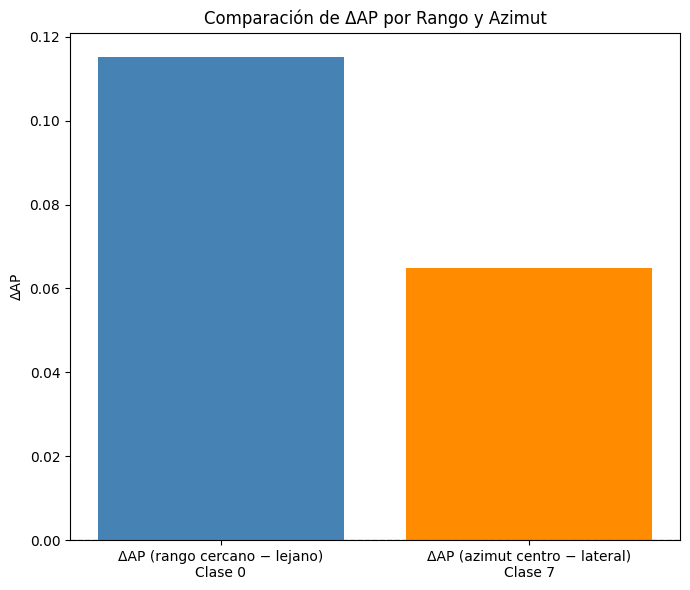

In [ ]:
import matplotlib.pyplot as plt

# Extraemos los valores
delta_rango = resumen_0_7['Δ_AP_rango'].iloc[0]   # clase 0
delta_azimut = resumen_0_7['Δ_AP_azimut'].iloc[0] # clase 7

# Datos para graficar
valores = [delta_rango, delta_azimut]
etiquetas = ['ΔAP (rango cercano − lejano)\nClase 0',
             'ΔAP (azimut centro − lateral)\nClase 7']
colores = ['steelblue', 'darkorange']

# Gráfico
plt.figure(figsize=(7, 6)) # Adjusted figure size
plt.bar(etiquetas, valores, color=colores)
plt.axhline(0, color='grey', linestyle='--', linewidth=1) # Changed line color
plt.ylabel('ΔAP')
plt.title('Comparación de ΔAP por Rango y Azimut') # Added a more descriptive title

# Etiquetas numéricas encima de las barras
# for i, v in enumerate(valores):
#     plt.text(i, v + 0.005 if v >= 0 else v - 0.02,
#              f"{v:.3f}", ha='center', va='bottom' if v>=0 else 'top', fontsize=10)

plt.tight_layout()
plt.show()

Se puede observar como, en este caso, eligiendo distribuciones de clases uniformes y umbrales en los que el numero en cada grupo es tambien uniforme, los resultados mejoran para distancias menores y angulos centrados.

In [ ]:
#creamos ahora una funcion para calcular el AP vs el resto
def ap_por_clase(df, classes):

    resultados = {}
    for c in classes:
        y_true = (df['y_true'] == c).astype(int)
        y_score = df[f'prob_{c}']
        # Evitar errores si hay muy pocas muestras de una clase
        if y_true.sum() > 0 and y_true.sum() < len(y_true):
            ap = average_precision_score(y_true, y_score)
        else:
            ap = np.nan
        resultados[c] = ap
    return resultados

In [ ]:
ap_range_close = ap_por_clase(rango_cercano, classes)
ap_range_far   = ap_por_clase(rango_lejano, classes)
ap_az_centro   = ap_por_clase(azimut_centro, classes)
ap_az_lateral  = ap_por_clase(azimut_lateral, classes)

Vamos a representar los resultados de forma gráfica para ver si a primera vista podemos ver alguna diferencia

In [ ]:
#unificamos resultados en una gráfica
resumen = pd.DataFrame({
    'Clase': classes,
    'AP_rango_cercano': [ap_range_close[c] for c in classes],
    'AP_rango_lejano': [ap_range_far[c] for c in classes],
    'AP_azimut_centro': [ap_az_centro[c] for c in classes],
    'AP_azimut_lateral': [ap_az_lateral[c] for c in classes],
})

In [ ]:
print(resumen)

   Clase  AP_rango_cercano  AP_rango_lejano  AP_azimut_centro  \
0      0          0.559748         0.444546          0.477148   
1      1          0.394070         0.272878          0.225936   
2      5          0.233552         0.136153          0.161249   
3      7          0.811960         0.969592          0.899109   
4     10          0.003153         0.063538          0.005501   
5     11          0.510835         0.771589          0.708159   

   AP_azimut_lateral  
0           0.499064  
1           0.335911  
2           0.230376  
3           0.834244  
4           0.070562  
5           0.623644  


In [ ]:
#calculamos diferencias entre variables
resumen['Δ_AP_rango']  = resumen['AP_rango_cercano'] - resumen['AP_rango_lejano']
resumen['Δ_AP_azimut'] = resumen['AP_azimut_centro'] - resumen['AP_azimut_lateral']

In [ ]:
print(resumen)

   Clase  AP_rango_cercano  AP_rango_lejano  AP_azimut_centro  \
0      0          0.559748         0.444546          0.477148   
1      1          0.394070         0.272878          0.225936   
2      5          0.233552         0.136153          0.161249   
3      7          0.811960         0.969592          0.899109   
4     10          0.003153         0.063538          0.005501   
5     11          0.510835         0.771589          0.708159   

   AP_azimut_lateral  Δ_AP_rango  Δ_AP_azimut  
0           0.499064    0.115202    -0.021915  
1           0.335911    0.121192    -0.109974  
2           0.230376    0.097399    -0.069127  
3           0.834244   -0.157632     0.064865  
4           0.070562   -0.060385    -0.065061  
5           0.623644   -0.260754     0.084515  


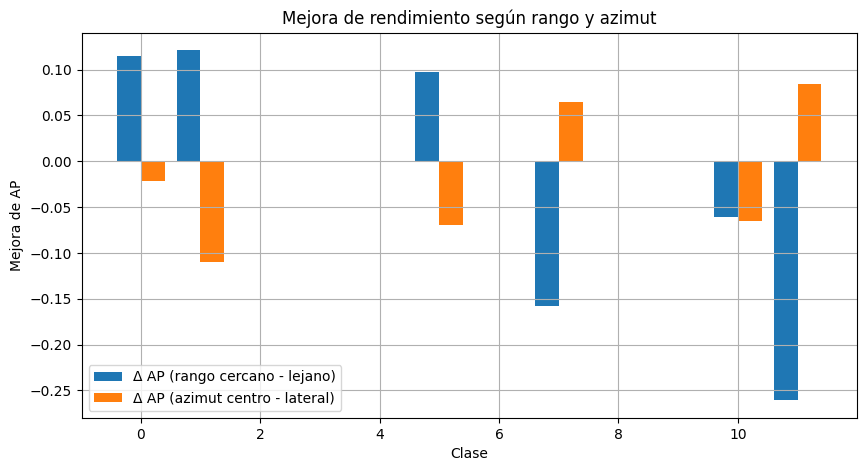

In [ ]:
plt.figure(figsize=(10,5))
plt.bar(resumen['Clase'] - 0.2, resumen['Δ_AP_rango'], width=0.4, label='Δ AP (rango cercano - lejano)')
plt.bar(resumen['Clase'] + 0.2, resumen['Δ_AP_azimut'], width=0.4, label='Δ AP (azimut centro - lateral)')
plt.xlabel("Clase")
plt.ylabel("Mejora de AP")
plt.title("Mejora de rendimiento según rango y azimut")
plt.legend()
plt.grid(True)
plt.show()

Aunque teóricamente el modelo debería rendir mejor en distancias cortas y ángulos de azimut cercanos a 0, los resultados obtenidos muestran una tendencia irregular y que no sigue ningun patron concreto. La hipótesis física sigue siendo válida, pero los datos y el modelo no permiten observar una mejora clara y consistente de AP en las zonas teóricamente favorables. Es decir, para cada clase tenemos que ver que la dsitribucion sea uniforme y definir unos umbrales adecuados para poder ver unos resultados que no estén sesgados como en el primer caso del apartado

##Apartado 7

Elegir un punto de operación (umbral) de la curva de PR asociada a la clase persona vs
resto en entrenamiento y comprobar los valores de Precision y Recall en validación
correspondientes al umbral previamente definido en entrenamiento. Se pide priorizar la
precisión del modelo ¿Los resultados son similares entre training y validation? Justifica la
respuesta

A priori, si se nos pide priorizar la precisión, nos situaremos en la parte izquierda de la curva ROC. Es decir, no detectaremos todos los positivos pero los que detectemos serán verdadero.

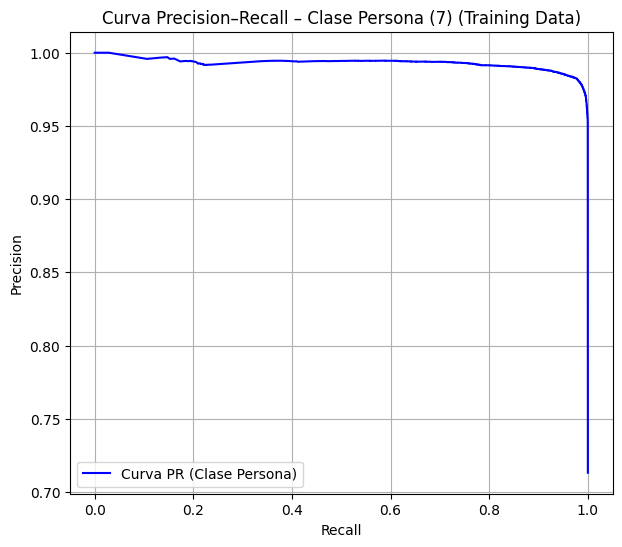

In [ ]:
#Representamos la curva ROC de los datos del training
from sklearn.metrics import precision_recall_curve

idx_persona = list(modelo_class.classes_).index(7)


y_true_train = (y_sample == 7).astype(int)
y_scores_train = y_train_proba[:, idx_persona]

# Calculate precision, recall, and thresholds
precision_train, recall_train, thresholds_train = precision_recall_curve(y_true_train, y_scores_train)

# Plot the Precision-Recall curve
plt.figure(figsize=(7, 6))
plt.plot(recall_train, precision_train, color='blue', label='Curva PR (Clase Persona)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision–Recall – Clase Persona (7) (Training Data)')
plt.legend()
plt.grid(True)
plt.show()

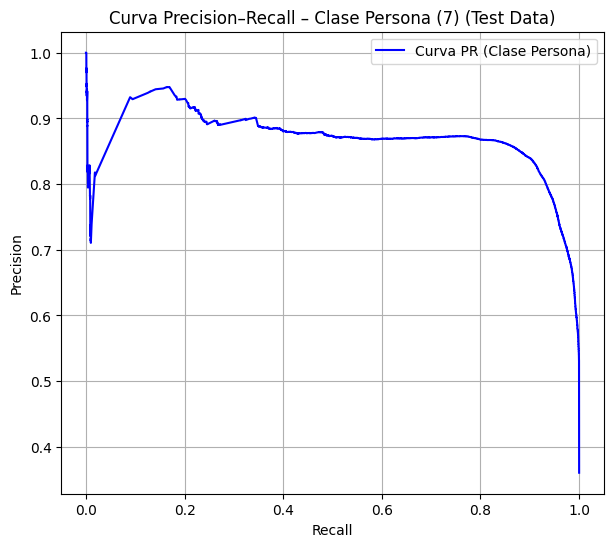

In [ ]:
#representamos la curva ROC para los datos de test
from sklearn.metrics import precision_recall_curve


idx_persona = list(modelo_class.classes_).index(7)


y_true_test = (y_test == 7).astype(int)
y_scores_test = y_test_proba[:, idx_persona]

# Calculate precision, recall, and thresholds
precision_test, recall_test, thresholds_test = precision_recall_curve(y_true_test, y_scores_test)

# Plot the Precision-Recall curve
plt.figure(figsize=(7, 6))
plt.plot(recall_test, precision_test, color='blue', label='Curva PR (Clase Persona)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision–Recall – Clase Persona (7) (Test Data)')
plt.legend()
plt.grid(True)
plt.show()

Vemos ya a priori diferencias entre las curvas ROC con los datos de entrenamiento y los datos de test. El caso de la curva ROC de validación es peculiar pero es un caso que se puede dar. Podría ser que parte de los datos iniciales estén mal etiquetados, es decir, que fuera una persona pero este puesto como que no es persona. Sin embargo, para comprobar esta hipótesis, tendríamos que acceder a las imagenes del radar. También podría darse el caso de que el modelo estuviera fallando pero es algo más improbable

No obstante, vamos a profundizar un poco más y ver que registros son lo que causan esta anomalía en la curva.

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# --- 1) Curva PR para persona (clase 7)
idx_persona = list(modelo_class.classes_).index(7)
y_true = (y_test == 7).astype(int)
scores = y_test_proba[:, idx_persona]

precision, recall, thresholds = precision_recall_curve(y_true, scores)
pr = pd.DataFrame({
    "threshold": np.r_[thresholds, 0.0],   # sklearn añade un punto extra
    "precision": precision,
    "recall": recall
})
pr["dP"] = pr["precision"].diff()
pr["dR"] = pr["recall"].diff()

# --- 2) Elige un umbral en el tramo "irregular" (recall muy bajo)
#   Regla simple: dentro de recall ∈ [0.01, 0.05], coge el mínimo de precisión
cand = pr[(pr["recall"] >= 0.01) & (pr["recall"] <= 0.05)]
t_star = float(cand.loc[cand["precision"].idxmin(), "threshold"]) if not cand.empty else float(thresholds[0])

# Métricas en t_star
pred = (scores >= t_star)
TP = int(((pred == 1) & (y_true == 1)).sum())
FP = int(((pred == 1) & (y_true == 0)).sum())
FN = int(((pred == 0) & (y_true == 1)).sum())
prec_star = TP / (TP + FP) if (TP + FP) > 0 else np.nan
rec_star  = TP / (TP + FN) if (TP + FN) > 0 else np.nan
print(f"Umbral elegido t* = {t_star:.4f}  →  Precision={prec_star:.3f}  Recall={rec_star:.3f}  (TP={TP}, FP={FP}, FN={FN})")

# --- 3) Tabla de inspección (añade features si test_df existe)
df_inspect = pd.DataFrame({
    "y_true": y_true,
    "score": scores,
    "pred": pred.astype(int)
})
df_inspect["error"] = np.where((df_inspect["pred"]==1) & (df_inspect["y_true"]==0), "FP",
                        np.where((df_inspect["pred"]==0) & (df_inspect["y_true"]==1), "FN",
                        np.where((df_inspect["pred"]==1) & (df_inspect["y_true"]==1), "TP", "TN")))

# adjunta columnas útiles si están disponibles
try:
    extra_cols = [c for c in ["range_sc","azimuth_sc","radar_cross_section","radial_velocity",
                              "vr_compensated","x_cc","y_cc","x_seq","y_seq"] if c in test_df.columns]
    if len(extra_cols):
        df_inspect = pd.concat([df_inspect.reset_index(drop=True),
                                test_df[extra_cols].reset_index(drop=True)], axis=1)
except NameError:
    pass  # si no existe test_df, seguimos solo con score/y_true

# Top casos a revisar
top_fp = df_inspect[df_inspect["error"]=="FP"].nlargest(15, "score")
top_fn = df_inspect[df_inspect["error"]=="FN"].nsmallest(15, "score")

print("\n>> FALSOS POSITIVOS con score más alto (candidatos a mal etiquetado o hard negatives):")
display(top_fp)


Umbral elegido t* = 0.9722  →  Precision=0.739  Recall=0.012  (TP=831, FP=293, FN=71273)

>> FALSOS POSITIVOS con score más alto (candidatos a mal etiquetado o hard negatives):


,y_true,score,pred,error,range_sc,azimuth_sc,radar_cross_section,radial_velocity,vr_compensated,x_cc,y_cc,x_seq,y_seq
3055,0,0.980340,1,FP,80.625220,0.355410,2.598114,1.417304,1.417237,84.222340,-7.205443,-265.019620,-82.813970
83988,0,0.980301,1,FP,62.738350,0.504389,-1.509755,1.560486,1.560318,66.452484,3.575643,-154.730550,-68.325775
41073,0,0.979572,1,FP,62.932655,0.511391,1.628048,1.605789,1.610429,66.614770,4.028435,-104.167570,-120.246730
133802,0,0.979312,1,FP,63.793163,0.498720,4.369286,1.591786,1.591950,67.528470,3.286644,-103.973076,-119.086200
44373,0,0.979205,1,FP,64.710420,0.503555,3.013301,1.458086,1.463075,68.423630,3.656196,-104.735990,-118.489690
44465,0,0.978429,1,FP,62.517384,0.506004,-4.906186,1.457452,1.457283,66.225075,3.661288,-154.971570,-68.357086
93640,0,0.977768,1,FP,63.732246,0.493744,6.280896,1.589190,1.594021,67.486700,2.966321,-103.673730,-118.964480
50789,0,0.977615,1,FP,61.468040,0.512762,0.025150,1.599575,1.604734,65.147900,4.002420,-103.421650,-121.510090
61798,0,0.976865,1,FP,6.930009,-0.018310,-17.766832,2.689525,2.698510,10.086492,-3.742339,-215.578690,-62.427567
26127,0,0.976134,1,FP,9.856063,0.072285,-23.608198,2.166107,2.176161,13.070646,-4.207987,-212.669270,-61.615460


Estos son los casos con mayor probabilidad de ser personas y que no esten clasificadas como ello. Son los responsables de ese valle en el inicio de la curva

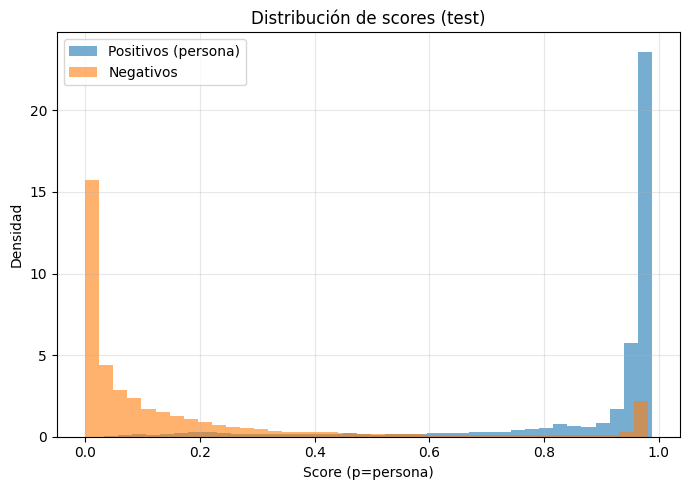

In [ ]:
import numpy as np, matplotlib.pyplot as plt

idx_persona = list(modelo_class.classes_).index(7)
y_true = (y_test == 7).astype(int)
scores = y_test_proba[:, idx_persona]

plt.figure(figsize=(7,5))
plt.hist(scores[y_true==1], bins=40, alpha=0.6, density=True, label='Positivos (persona)')
plt.hist(scores[y_true==0], bins=40, alpha=0.6, density=True, label='Negativos')
plt.xlabel('Score (p=persona)'); plt.ylabel('Densidad'); plt.title('Distribución de scores (test)')
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()


Este histograma es muy representativo, en el que vemos como esos negativos de la parte derecha se solapan con los positivos. Provocando lo mencionado anteriormente, un valle en la curva precision-recall.

Pasamos ahora a establecer un punto de operacion mediante el umbral

In [ ]:
from sklearn.metrics import precision_score,recall_score

#establecemos un umbral en 0.9, priorizando la precision
threshold_opt=0.9

#calculamos precision y recall para los datos de entrenamiento
y_pred_train = (y_scores_train >= threshold_opt).astype(int) #filtramos para las probabilidades de ser persona por encima de 0.8
prec_train = precision_score(y_true_train, y_pred_train) #calculamos el precision con la funcion, metiendo los valores reales y las probabilidades
rec_train  = recall_score(y_true_train, y_pred_train) #calculamos el recall con la funcion, metiendo tambien los valores reales y las probabilidades

#ahora lo calculamos precision y recall para los datos de test
y_pred_test = (y_scores_test >= threshold_opt).astype(int)
prec_test   = precision_score(y_true_test, y_pred_test)
rec_test    = recall_score(y_true_test, y_pred_test)

print(f"Train -> Precision: {prec_train:.3f}, Recall: {rec_train:.3f}")
print(f"Validation -> Precision: {prec_test:.3f}, Recall: {rec_test:.3f}")

Train -> Precision: 0.987, Recall: 0.932
Validation -> Precision: 0.873, Recall: 0.774


Con un umbral del 90% el modelo logra un 98.7% de precision y un 93.2% de precision con los datos de entrenamiento, resultados realmente buenos. Sin embargo, con los datos de test se consigue una precision del 87.3% y un 77.4% de recall. Los resultados también son muy buenos y parecidos a los anteriores pero inferiores. Esto se debe al overfitting del modelo, empeorando su desempeño con datos con los que no ha sido entrenado.

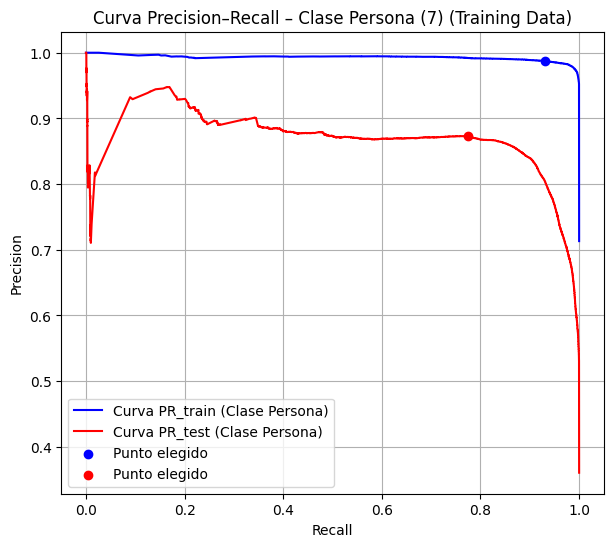

In [ ]:
#podemos representar el punto de funcionamiento tanto con los datos de entrenamiento como con los de test
plt.figure(figsize=(7, 6))
plt.plot(recall_train, precision_train, color='blue', label='Curva PR_train (Clase Persona)')
plt.plot(recall_test, precision_test, color='red', label='Curva PR_test (Clase Persona)')
plt.scatter(rec_train, prec_train, color='blue', label='Punto elegido')
plt.scatter(rec_test, prec_test, color='red', label='Punto elegido')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision–Recall – Clase Persona (7) (Training Data)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
from sklearn.metrics import precision_recall_curve

prec, rec, thr = precision_recall_curve(y_true, scores)
head = pd.DataFrame({
    "threshold": np.r_[thr, 0.0],
    "precision": prec, "recall": rec
}).query("recall <= 0.06").sort_values("threshold", ascending=False)
head.head(12)


,threshold,precision,recall
106513,0.987417,1.0,0.000014
106512,0.986821,1.0,0.000028
106511,0.986414,1.0,0.000042
106510,0.986187,1.0,0.000055
106509,0.986064,1.0,0.000069
106508,0.985192,1.0,0.000083
106507,0.985077,1.0,0.000097
106506,0.985048,1.0,0.000111
106505,0.984224,1.0,0.000125
106504,0.983650,1.0,0.000139
